# AAI 511 Final Project - Victor Hsu, Keith Holder - Composer Prediction Model

The code below shows our process for building a Composer prediction model

# Data collection

Unzip initial composers from kaggle website

In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Extract Music Files
zip_path = '/content/drive/My Drive/AAI511_ML/midi_classic_music.zip'
extract_path = '/content/midi_classic_music/'

# Unzip the file.
!unzip -q -n "{zip_path}" -d "{extract_path}"

Mounted at /content/drive


# Keep only the composers mentioned in the final project

select the required composers from the given dataset.

1-Bach

2-Beethoven

3-Chopin

4-Mozart

In [2]:
import shutil

composers = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

for item in os.listdir(extract_path):
    item_path = os.path.join(extract_path, item)
    if os.path.isfile(item_path) and (item.endswith('.mid') or item.endswith('.MID')):
        os.remove(item_path)
        # print(f"Remove file at root: {item}")

midi_classic_path = extract_path + 'midiclassics'

for item in os.listdir(midi_classic_path):
    item_path = os.path.join(midi_classic_path, item)
    if os.path.isfile(item_path) and (item.endswith('.mid') or item.endswith('.MID')):
        os.remove(item_path)
        # print(f"Remove file at midi_classic_path: {item}")

# remove rest of non-composer files.
for root, dirs, files in os.walk(extract_path, topdown=False):
    for dir_name in dirs:
        if dir_name in composers:
            continue  # Keep this directory

        full_path = os.path.join(root, dir_name)
        contains_desired = False

        for subroot, subdirs, subfiles in os.walk(full_path):
            if any(composer in subdirs for composer in composers):
                contains_desired = True
                break

        if not contains_desired:
            shutil.rmtree(full_path)
            # print(f"Removed: {full_path}") for debugging

# Pre-processing - feature extraction

Convert the musical scores into a format suitable for deep learning models. This involves converting the musical scores into MIDI files and applying data augmentation techniques. Feature extraction happens for notes, chords, etc. We parsed the MIDI files to extract musical notes/chords, and then built a vocabulary, converting into sequences that the model can process.

In [3]:
!pip install music21
!pip install mido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 436.7 kB/s eta 0:00:00


In [4]:
#
# A script for preprocessing MIDI files for composer identification.
#
# Major Improvements:
# 1. Enriched Features: Extracts not just notes, but also duration and velocity (dynamics)
#    to create a much richer representation of musical style.
# 2. Correct Data Handling for NNs: Prepares integer-encoded sequences for use with
#    an Embedding layer, which is the correct approach for categorical data.
# 3. Robust Vocabulary: Builds a vocabulary only from the training set to prevent
#    data leakage and filters out rare events to reduce noise.
#
import mido
import music21
from pathlib import Path
from collections import Counter
from multiprocessing import Pool, cpu_count
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

# --- Configuration ---
MIDI_ROOT_DIR = '/content/midi_classic_music/midiclassics/'
SEQUENCE_LENGTH = 100 # The length of a sequence fed to the model
MIN_VOCAB_FREQUENCY = 10 # Minimum times an event must appear to be in the vocabulary
UNKNOWN_TOKEN = '<UNK>' # Token for events not in the vocabulary

print("Pre-computing MIDI note names for optimization")
MIDI_NOTE_TO_NAME = {}
PITCH_NAMES = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
for midi_note in range(128):
    # The formula for MIDI octave is (note // 12) - 1
    octave = (midi_note // 12) - 1
    # The pitch name is the remainder when divided by 12
    pitch = PITCH_NAMES[midi_note % 12]
    MIDI_NOTE_TO_NAME[midi_note] = f"{pitch}{octave}"
# created lookup table to improve speed of parsing

# --- Helper Functions for Feature Extraction ---
def quantize_duration(delta_time):
    """Quantizes a time delta (in seconds) into discrete categories."""
    if delta_time < 0.03:
        return 'grace'  # Very short, like a grace note
    if delta_time < 0.1:
        return '32nd'
    if delta_time < 0.2:
        return '16th'
    if delta_time < 0.4:
        return '8th'
    if delta_time < 0.8:
        return 'quarter'
    if delta_time < 1.5:
        return 'half'
    return 'whole'

def quantize_velocity(velocity):
    """Quantizes a MIDI velocity (0-127) into discrete categories."""
    if velocity < 35:
        return 'pianissimo' # pp
    if velocity < 60:
        return 'piano' # p
    if velocity < 85:
        return 'mezzo-forte' # mf
    if velocity < 110:
        return 'forte' # f
    return 'fortissimo' # ff

def get_songs_by_composer(root_dir):
    """Finds all MIDI files and groups them by composer from the directory structure."""
    songs_dict = {}
    root_path = Path(root_dir)
    for composer_path in root_path.iterdir():
        if composer_path.is_dir():
            composer_name = composer_path.name.lower()
            # CORRECTED: Use *.mid to find MIDI files, not .mid
            songs_dict[composer_name] = list(composer_path.glob('**/*.mid'))
    return songs_dict

def parse_rich_features_from_file(file_path):
    """
    Parses a MIDI file to extract rich musical events.
    An event is a combination of pitch, duration, and velocity.
    """
    events = []
    try:
        midi_file = mido.MidiFile(file_path)

        # initialize lists
        current_notes = []
        current_velocities = []
        # We process events in "time steps". A time step contains all notes that start simultaneously.
        for msg in mido.merge_tracks(midi_file.tracks):
            # A delta time > 0 means we have moved to a new time step.
            if msg.time > 0:
                # Get the quantized duration from the delta time of the current message
                duration = quantize_duration(msg.time)

                # The notes being processed are from the previous time step.
                # We now know their duration, so we can create the event string.
                if current_notes:
                    avg_velocity = quantize_velocity(np.mean(current_velocities))
                    current_notes.sort()
                    note_str = '.'.join(current_notes)

                    event_str = f"p={note_str}_d={duration}_v={avg_velocity}"
                    events.append(event_str)

                    # Reset for the new time step
                    current_notes = []
                    current_velocities = []

            # Capture all notes that are "note_on" at the current time step
            if msg.type == 'note_on' and msg.velocity > 0:
                pitch_name = MIDI_NOTE_TO_NAME[msg.note]
                current_notes.append(pitch_name)
                current_velocities.append(msg.velocity)

    except Exception as e:
        print(f" - Could not parse {file_path}: {e}")

    return events


def create_sequences_from_file_dict(file_dict, file_to_events_map, event_to_int, composer_map, sequence_length, step=10):
    """
    Creates integer sequences from a dictionary of files.

    OPTIMIZED with a step parameter to generate fewer, less-redundant sequences.
    """
    network_input, network_output = [], []
    unk_token_int = event_to_int.get(UNKNOWN_TOKEN)

    for composer_name, song_files in file_dict.items():
        composer_id = composer_map[composer_name]

        for song_file in song_files:
            events_in_song = file_to_events_map.get(song_file, [])

            if len(events_in_song) > sequence_length:
                # sliding window
                for i in range(0, len(events_in_song) - sequence_length, step):
                    sequence_in = events_in_song[i : i + sequence_length]
                    int_sequence = [event_to_int.get(event, unk_token_int) for event in sequence_in]

                    if None not in int_sequence:
                        network_input.append(int_sequence)
                        network_output.append(composer_id)

    return network_input, network_output

# --- Main Execution Block ---
if __name__ == '__main__':
    # Step 1: Discover files and create train/validation split
    # We split by files (musical works) BEFORE any processing to prevent data leakage.
    print("Step 1: Finding MIDI files and creating train/val split...")
    songs_dict = get_songs_by_composer(MIDI_ROOT_DIR)

    all_composers = sorted(songs_dict.keys())
    composer_map = {name: i for i, name in enumerate(all_composers)}
    num_classes = len(all_composers)

    train_files, val_files = {}, {}
    for composer, files in songs_dict.items():
        if len(files) > 1:
            train_f, val_f = train_test_split(files, test_size=0.2, random_state=42)
            train_files[composer] = train_f
            val_files[composer] = val_f
    print("Train/Validation split complete.")

    # Step 2: Parse all MIDI files to extract rich features in parallel
    print(f"\nStep 2: Parsing all MIDI files with {cpu_count()} cores...")
    all_files = [f for files in songs_dict.values() for f in files]
    with Pool() as pool:
        all_event_lists = pool.map(parse_rich_features_from_file, all_files)
    file_to_events_map = dict(zip(all_files, all_event_lists))
    print("Parsing complete.")

    # Step 3: Build a robust vocabulary from the TRAINING data ONLY
    print("\nStep 3: Building vocabulary from training data...")
    train_files_flat = [f for files in train_files.values() for f in files]
    train_events = [event for f in train_files_flat for event in file_to_events_map[f]]

    event_counts = Counter(train_events)

    # Filter vocabulary to include only events that appear frequently enough
    original_vocab_size = len(event_counts)
    filtered_events = [event for event, count in event_counts.items() if count >= MIN_VOCAB_FREQUENCY]

    # Create the final vocabulary and mappings
    vocab = [UNKNOWN_TOKEN] + filtered_events
    n_vocab = len(vocab)
    event_to_int = {event: i for i, event in enumerate(vocab)}

    print(f"Vocabulary built. Original size: {original_vocab_size}, Filtered size: {n_vocab}")
    print("Example event string:", np.random.choice(filtered_events))

    # Step 4: Create training and validation sequences
    print("\nStep 4: Creating integer sequences for training and validation...")
    train_input, train_output = create_sequences_from_file_dict(
        train_files, file_to_events_map, event_to_int, composer_map, SEQUENCE_LENGTH
    )
    val_input, val_output = create_sequences_from_file_dict(
        val_files, file_to_events_map, event_to_int, composer_map, SEQUENCE_LENGTH
    )

    # Step 5: Final data preparation for the model
    # The data is now integer-encoded.
    train_input = np.array(train_input)
    train_output = tf.keras.utils.to_categorical(np.array(train_output), num_classes=num_classes)
    val_input = np.array(val_input)
    val_output = tf.keras.utils.to_categorical(np.array(val_output), num_classes=num_classes)

Pre-computing MIDI note names for optimization
Step 1: Finding MIDI files and creating train/val split...
Train/Validation split complete.

Step 2: Parsing all MIDI files with 8 cores...
 - Could not parse /content/midi_classic_music/midiclassics/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Parsing complete.

Step 3: Building vocabulary from training data...
Vocabulary built. Original size: 69518, Filtered size: 5219
Example event string: p=A#4.F#3_d=whole_v=forte

Step 4: Creating integer sequences for training and validation...


# Saving pre-processed data

Saving to speed up execution later on.

In [41]:
# saved preprocessed data for later to save time.

drive.mount('/content/drive')
os.makedirs('/content/drive/MyDrive/AAI511_ML', exist_ok=True)

# we had to go through several iterations to get this right!
save_path = '/content/drive/MyDrive/AAI511_ML/preprocessed_composer_data_v7.npz'

print(f"\nSaving pre-processed data to {save_path}...")

np.savez_compressed(
        save_path,
        train_input=train_input,
        train_output=train_output,
        val_input=val_input,
        val_output=val_output,
        event_to_int=event_to_int,
        composer_map=composer_map,
        n_vocab=n_vocab
    )

# old method
# np.savez_compressed(
#     save_path,
#     network_input=network_input,
#     network_output=network_output,
#     n_vocab=np.array([n_vocab]), # Save n_vocab as a numpy array
#     composer_map=composer_map,   # Save the composer mapping dictionary
#     note_to_int=note_to_int      # Save the note mapping dictionary
# )

print("Data saved")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Saving pre-processed data to /content/drive/MyDrive/AAI511_ML/preprocessed_composer_data_v7.npz...
Data saved


## Model Training

data validation - make sure the data is what we expect from the preprocessing step
split - split into train/test/validation


In [ ]:
!pip install --upgrade numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 105.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.2 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.2 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.2 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.2 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.

In [6]:
import numpy as np
print(f"NumPy version THIS session is using: {np.__version__}")
import os
from google.colab import drive
import zipfile

# Mount Google Drive
drive.mount('/content/drive')

save_path = '/content/drive/MyDrive/AAI511_ML/preprocessed_composer_data_v7.npz'

# print(f"Inspecting arrays inside: {save_path}\n") for debugging

try:
    with zipfile.ZipFile(save_path) as zf:
        for name in zf.namelist():
            if not name.endswith('.npy'):
                continue

            with zf.open(name) as fp:
                # get the file format version
                version = np.lib.format.read_magic(fp)

                # Call the correct header function based on the version
                if version[0] == 1:
                    shape, fortran_order, dtype = np.lib.format.read_array_header_1_0(fp)
                elif version[0] == 2:
                    shape, fortran_order, dtype = np.lib.format.read_array_header_2_0(fp)
                else:
                    print(f"--> Array: '{name.replace('.npy', '')}' has an unsupported format version: {version}")
                    continue

                array_name = name.replace('.npy', '')
                # more debugging
                # print(f"--> Array: '{array_name}'")
                # print(f"    Shape: {shape}")
                # print(f"    Data Type (dtype): {dtype}")
                # print("-" * 20)

except Exception as e:
    print(f"An error occurred while inspecting the file: {e}")

NumPy version THIS session is using: 2.0.2
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the preprocessed data
print(f"Loading preprocessed data from: {save_path}")
with np.load(save_path, allow_pickle=True) as data:
    train_input = data['train_input']
    train_output = data['train_output']
    val_input = data['val_input']
    val_output = data['val_output']
    composer_map = data['composer_map'].item()
    event_to_int = data['event_to_int'].item()
    sequence_length = train_input.shape[1]

    try:
        n_vocab = data['n_vocab'].item()
    except KeyError:
        # If not in npz, use note_to_int
        print('unexpected KeyError')

print("Data loaded!")

# Split data into training (80%) and validation (20%) sets - no longer needed as we split in the preprocessing stages
# print("Splitting data into training and validation sets...")
# X_train, X_val, y_train, y_val = train_test_split(
#     train_input,
#     train_output,
#     test_size=0.2,
#     random_state=42, # for reproducibility
#     stratify=train_output # Ensures same class distribution in train/val sets
# )

X_train = train_input
y_train = train_output
X_val = val_input
y_val = val_output

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Number of vocab: {n_vocab}")

Loading preprocessed data from: /content/drive/MyDrive/AAI511_ML/preprocessed_composer_data_v7.npz
Data loaded!
Training samples: 64266
Validation samples: 16209
Number of vocab: 5219


In [13]:
def create_optimized_dataset(features, labels, batch_size=64, is_training=True):
    """Create an optimized dataset."""
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    if is_training:
        dataset = dataset.shuffle(len(features), reshuffle_each_iteration=True)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Create the datasets
BATCH_SIZE = 128
train_dataset = create_optimized_dataset(X_train, y_train, batch_size=BATCH_SIZE)
validation_dataset = create_optimized_dataset(X_val, y_val, batch_size=BATCH_SIZE, is_training=False)

print("\nTensorFlow datasets created.")


TensorFlow datasets created.


## Define/Compile LSTM-CNN Model

In [20]:
# original
# def build_cnn_lstm_model(input_shape, num_classes):
#     """Builds a hybrid CNN-LSTM model for sequence classification."""
#     model = tf.keras.Sequential([
#         # Input Layer
#         tf.keras.layers.Input(shape=input_shape),

#         # 1. CNN Block: To find local musical patterns
#         tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding='causal'),
#         tf.keras.layers.MaxPooling1D(pool_size=2),
#         tf.keras.layers.Dropout(0.2),

#         # 2. LSTM Block: To learn long-term structure
#         tf.keras.layers.LSTM(256, return_sequences=False),
#         tf.keras.layers.Dropout(0.3),

#         # 3. Classification
#         tf.keras.layers.Dense(128, activation='relu'),
#         tf.keras.layers.Dense(num_classes, activation='softmax') # Softmax for multi-class classification
#     ])
#     return model

# --- Updated Model Definition ---
def build_cnn_lstm_model(input_shape, num_classes, n_vocab):
    """
    Builds a hybrid CNN-LSTM model with an Embedding layer.
    This is the CORRECT way to process categorical sequence data.
    """
    model = tf.keras.Sequential([
        # The input_shape is now just the sequence length, e.g., (100,)
        tf.keras.layers.Input(shape=input_shape),

        # 1. Embedding Layer
        # This layer turns integer IDs into dense vectors.
        # It learns relationships between musical events.
        # input_dim: The size of our vocabulary (n_vocab)
        # output_dim: The size of the vector for each event (a hyperparameter)
        tf.keras.layers.Embedding(input_dim=n_vocab, output_dim=128),

        # 2. CNN Block (operates on the learned embeddings)
        tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding='causal',
                               kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Dropout(0.25),

        # 3. LSTM Block
        tf.keras.layers.LSTM(256, return_sequences=False,
                             kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.35),

        # 4. Classification Head
        tf.keras.layers.Dense(128, activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Get model parameters from the data
input_shape = X_train.shape[1:]
num_classes = len(np.unique(train_output))
print(len(np.unique(train_output)))
print(composer_map)

# Build and compile the model
print("\nBuilding and compiling the model...")
model = build_cnn_lstm_model(input_shape=input_shape, num_classes=4, n_vocab=n_vocab) # 4 is the num composers

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # adjusted learning rate after some attempts
    loss='categorical_crossentropy', # Use this for integer labels
    metrics=['accuracy']
)

model.summary()

2
{'bach': 0, 'beethoven': 1, 'chopin': 2, 'mozart': 3}

Building and compiling the model...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 128)       │       668,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 100, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,177,732 (4.49 MB)

 Trainable params: 1,177,732 (4.49 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Add a callback to stop training early if performance plateaus
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Stop after 5 epochs with no improvement
    restore_best_weights=True # Restore the best model weights found
)

print("\nStarting model training...")
history = model.fit(
    train_dataset,
    epochs=40, # Set a high number, early stopping will find the best epoch
    validation_data=validation_dataset,
    callbacks=[early_stopping]#,
    # verbose=0 # to keep code clean
)
print("\nModel training complete")


Starting model training...
Epoch 1/40
503/503 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9941 - loss: 0.0525 - val_accuracy: 0.6081 - val_loss: 2.1882
Epoch 2/40
503/503 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9898 - loss: 0.0686 - val_accuracy: 0.6034 - val_loss: 2.1765
Epoch 3/40
503/503 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9944 - loss: 0.0492 - val_accuracy: 0.6380 - val_loss: 2.1884
Epoch 4/40
503/503 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9959 - loss: 0.0409 - val_accuracy: 0.5837 - val_loss: 2.9017
Epoch 5/40
503/503 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9856 - loss: 0.0861 - val_accuracy: 0.6433 - val_loss: 2.3460
Epoch 6/40
503/503 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9957 - loss: 0.0428 - val_accuracy: 0.5974 - val_loss: 2.3641
Epoch 7/40
503/503 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9950 - loss: 0.0427 - val_accuracy: 0.6153 - val_loss: 2.7053

Model training complete


In [26]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 909.6 kB/s eta 0:00:00


In [29]:
# above model reached a respectible .6433 val_accuracy rating. I wanted to see if I could improve it so tried a keras_tuner to find optimal learning rate.

import keras_tuner

def build_tunable_model(hp):
    """
    This is the complete, corrected model-building function for KerasTuner.
    """
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(SEQUENCE_LENGTH,)))

    # 1. Tune the Embedding layer
    hp_embedding_dim = hp.Int('embedding_dim', min_value=64, max_value=256, step=64)
    model.add(tf.keras.layers.Embedding(input_dim=n_vocab, output_dim=hp_embedding_dim))

    # 2. Tune the CNN block
    hp_cnn_filters = hp.Int('cnn_filters', min_value=64, max_value=256, step=64)
    model.add(tf.keras.layers.Conv1D(filters=hp_cnn_filters, kernel_size=5, activation='relu', padding='causal'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

    hp_dropout_1 = hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.05)
    model.add(tf.keras.layers.Dropout(hp_dropout_1))

    # 3. Tune the LSTM block
    hp_lstm_units = hp.Int('lstm_units', min_value=128, max_value=512, step=128)
    model.add(tf.keras.layers.LSTM(hp_lstm_units, return_sequences=False))

    hp_dropout_2 = hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.05)
    model.add(tf.keras.layers.Dropout(hp_dropout_2))

    # 4. Classification Head
    # This section was likely missing or incorrect in your previous version.
    model.add(tf.keras.layers.Dense(128, activation='relu'))

    # Ensure the final layer uses the 'num_classes'
    model.add(tf.keras.layers.Dense(4, activation='softmax'))

    # 5. Tune the learning rate and compile
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 5e-5])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = keras_tuner.Hyperband(build_tunable_model,
                              objective='val_accuracy',
                              max_epochs=20,
                              factor=3,
                              directory='my_tuning_dir',
                              project_name='composer_tuning')

# This will run the search for the best hyperparameters
tuner.search(train_input, train_output, epochs=50, validation_data=(val_input, val_output), callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best learning rate: {best_hps.get('learning_rate')}")



Trial 26 Complete [00h 02m 34s]
val_accuracy: 0.6448269486427307

Best val_accuracy So Far: 0.6593250632286072
Total elapsed time: 00h 41m 42s
Best learning rate: 0.001


In [30]:
print(f"Best learning rate: {best_hps.get('learning_rate')}")
print(f"CNN Filters:          {best_hps.get('cnn_filters')}")
print(f"Dropout Rate 1:       {best_hps.get('dropout_1'):.4f}")
print(f"LSTM Units:           {best_hps.get('lstm_units')}")
print(f"Dropout Rate 2:       {best_hps.get('dropout_2'):.4f}")

Best learning rate: 0.001
CNN Filters:          256
Dropout Rate 1:       0.3000
LSTM Units:           256
Dropout Rate 2:       0.2500
Learning Rate:        0.001


Using updated hyperparameters, attempt another round of model training

In [32]:
def create_final_model(n_vocab, num_classes, sequence_length):
    """
    Builds the final model using the optimal hyperparameters found by KerasTuner.
    """
    embedding_dim = 128

    model = tf.keras.Sequential([
        # Input Layer
        tf.keras.layers.Input(shape=(sequence_length,)),

        # Embedding Layer
        tf.keras.layers.Embedding(input_dim=n_vocab, output_dim=embedding_dim),

        # From tuner: CNN Filters = 256
        tf.keras.layers.Conv1D(filters=256, kernel_size=5, activation='relu', padding='causal'),
        tf.keras.layers.MaxPooling1D(pool_size=2),

        # From tuner: Dropout Rate 1 = 0.30
        tf.keras.layers.Dropout(0.30),

        # From tuner: LSTM Units = 256
        tf.keras.layers.LSTM(256, return_sequences=False),

        # From tuner: Dropout Rate 2 = 0.25
        tf.keras.layers.Dropout(0.25),

        # Classification Head
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ])

    return model
final_model = create_final_model(n_vocab, 4, sequence_length)

# 2. Compile the model with the optimal learning rate
# From tuner: Learning Rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
final_model.compile(optimizer=optimizer,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

print("Final Model Summary")
final_model.summary()

# 3. Train the model for a good number of epochs
print("\nTraining Final Model")
history = final_model.fit(
    train_input,
    train_output,
    epochs=100,  # Set a high number of epochs
    validation_data=(val_input, val_output),
    # Use EarlyStopping to prevent overfitting and save the best version of the model
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)]
)


--- Final Model Summary ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 128)       │       668,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 100, 256)       │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,390,852 (5.31 MB)

 Trainable params: 1,390,852 (5.31 MB)

 Non-trainable params: 0 (0.00 B)


--- Training Final Model ---
Epoch 1/100
2009/2009 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.7695 - loss: 0.6073 - val_accuracy: 0.6390 - val_loss: 1.4286
Epoch 2/100
2009/2009 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9721 - loss: 0.0870 - val_accuracy: 0.6284 - val_loss: 1.9318
Epoch 3/100
2009/2009 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9881 - loss: 0.0380 - val_accuracy: 0.6309 - val_loss: 1.9838
Epoch 4/100
2009/2009 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9940 - loss: 0.0209 - val_accuracy: 0.6152 - val_loss: 2.4915
Epoch 5/100
2009/2009 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9945 - loss: 0.0175 - val_accuracy: 0.6266 - val_loss: 2.5463
Epoch 6/100
2009/2009 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9957 - loss: 0.0129 - val_accuracy: 0.6159 - val_loss: 2.5140
Epoch 7/100
2009/2009 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9961 - loss: 0.0123 - val_accuracy: 0.6230 - val_loss: 2.8288
Epoch 8/100
2009/2009 ━━━━━━━━━━━━━━━━━━━━ 18s

Final Model reached a slightly improved 0.6454. For a last attempt, will try bidirectional LSTM, which uses our optimized hyperparameters from keras tuner.

In [33]:
# This function defines the new model architecture
def create_bidirectional_model(n_vocab, num_classes, sequence_length):
    """
    Builds the final model using a Bidirectional LSTM layer.
    """
    # Using the best hyperparameter values from your tuner search
    embedding_dim = 128  # A strong default choice
    cnn_filters = 256
    lstm_units = 256
    dropout_1 = 0.30
    dropout_2 = 0.25

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(sequence_length,)),
        tf.keras.layers.Embedding(input_dim=n_vocab, output_dim=embedding_dim),

        tf.keras.layers.Conv1D(filters=cnn_filters, kernel_size=5, activation='relu', padding='causal'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Dropout(dropout_1),
        # The LSTM layer is now wrapped in a Bidirectional layer.
        # This allows the model to learn context from both past and future events.
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=False)),

        tf.keras.layers.Dropout(dropout_2),

        # Classification Head
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ])

    return model

# --- Build, Compile, and Train the Final Model ---

print("Building the Bidirectional model...")
bi_model = create_bidirectional_model(n_vocab, 4, sequence_length)

print("Compiling model...")
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
bi_model.compile(optimizer=optimizer,
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

print("\nModel Summary")
bi_model.summary()

# 3. Train the model
print("\nTraining Bidirectional Model")
history = bi_model.fit(
    train_input,
    train_output,
    epochs=100,  # Set a high number and let EarlyStopping find the best epoch
    batch_size=64,
    validation_data=(val_input, val_output),
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10, # Stop if val_accuracy doesn't improve for 10 epochs
        restore_best_weights=True # Return the best version of the model
    )]
)

Building the Bidirectional model...
Compiling model...

Model Summary


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 128)       │       668,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 100, 256)       │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,948,932 (7.43 MB)

 Trainable params: 1,948,932 (7.43 MB)

 Non-trainable params: 0 (0.00 B)


Training Bidirectional Model
Epoch 1/100
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.7833 - loss: 0.5462 - val_accuracy: 0.6530 - val_loss: 1.4750
Epoch 2/100
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.9748 - loss: 0.0767 - val_accuracy: 0.6274 - val_loss: 1.9602
Epoch 3/100
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.9903 - loss: 0.0300 - val_accuracy: 0.6545 - val_loss: 1.9150
Epoch 4/100
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.9940 - loss: 0.0189 - val_accuracy: 0.6259 - val_loss: 2.5310
Epoch 5/100
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.9948 - loss: 0.0170 - val_accuracy: 0.6452 - val_loss: 2.6168
Epoch 6/100
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.9967 - loss: 0.0117 - val_accuracy: 0.6263 - val_loss: 2.6164
Epoch 7/100
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.9967 - loss: 0.0100 - val_accuracy: 0.6383 - val_loss: 2.7127
Epoch 8/100
1005/1005 ━━━━━━━━━━━━━━━━━

It seems this is the best we can do with this dataset, with val accuracy of 0.6545. We've optimized the parameters using keras tuner, and even gone out of our way to create a bidirectional model. We will save the bidirectional model and use it for our final evaluation.

In [44]:
import pickle

# save the model for later use, with meta data for easier testing.
bi_model.save('/content/drive/MyDrive/AAI511_ML/composer_classifier_model_v1_bidirectional.keras')
print("Model saved as 'composer_classifier_model.keras'")

model_metadata = {
    'composer_map': composer_map,
    'sequence_length': sequence_length,
    'n_vocab': n_vocab,
    'event_to_int': event_to_int
}

metadata_path = os.path.join('/content/drive/MyDrive/AAI511_ML/', 'model_metadata_v2.pkl')
with open(metadata_path, 'wb') as f:
    pickle.dump(model_metadata, f)
print(f"Metadata saved to: {metadata_path}")

Model saved as 'composer_classifier_model.keras'
Metadata saved to: /content/drive/MyDrive/AAI511_ML/model_metadata_v2.pkl


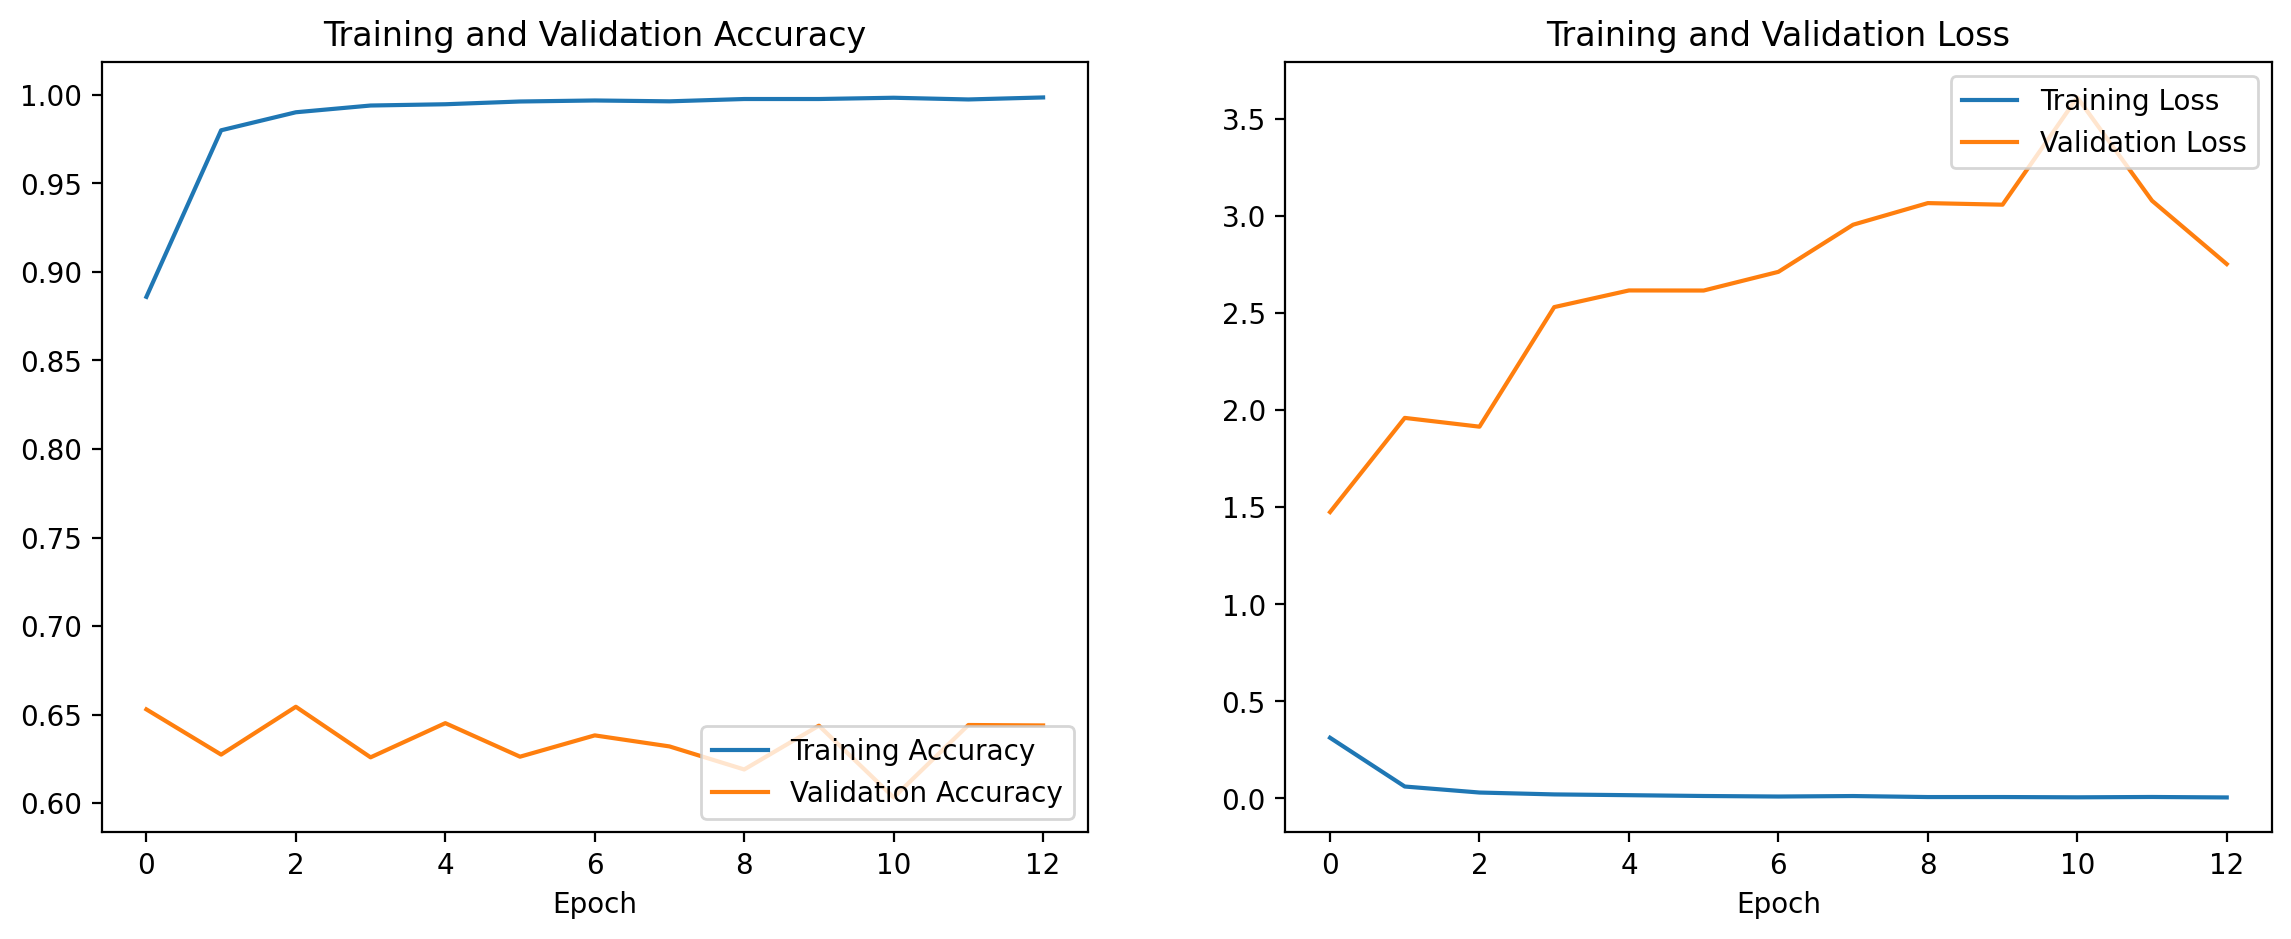

In [35]:
def plot_history(history):
    """Plots the training and validation accuracy and loss."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')

    plt.show()

plot_history(history)

In [45]:
# testing to make sure model works

def parse_rich_features_from_file(file_path):
    """The correct parser for creating rich event strings."""
    events = []
    try:
        midi_file = mido.MidiFile(file_path)
        current_notes, current_velocities = [], []
        for msg in mido.merge_tracks(midi_file.tracks):
            if msg.time > 0 and current_notes:
                duration = quantize_duration(msg.time)
                avg_velocity = quantize_velocity(np.mean(current_velocities))
                current_notes.sort()
                note_str = '.'.join(current_notes)
                event_str = f"p={note_str}_d={duration}_v={avg_velocity}"
                events.append(event_str)
                current_notes, current_velocities = [], []
            if msg.type == 'note_on' and msg.velocity > 0:
                # Calling music21 directly for each note since we arent optimizing for a few test cases
                pitch_name = music21.pitch.Pitch(midi=msg.note).nameWithOctave
                current_notes.append(pitch_name)
                current_velocities.append(msg.velocity)
    except Exception as e:
        print(f" - Could not parse {file_path}: {e}")
    return events

def predict_composer_for_file(file_path, model, metadata):
    """Processes a single MIDI file and predicts its composer."""

    print("-" * 40)
    print(f"Testing: {os.path.basename(file_path)}")

    # PARSE using the rich feature parser
    events = parse_rich_features_from_file(file_path)

    sequence_length = metadata['sequence_length']
    if len(events) < sequence_length:
        print(f"File is too short. Contains {len(events)} events, but model requires {sequence_length}.")
        return

    event_to_int = metadata['event_to_int']
    unk_token_int = event_to_int.get('<UNK>') # Handle events not seen in training

    test_events = events[:sequence_length]
    int_sequence = [event_to_int.get(event, unk_token_int) for event in test_events]
    test_input = np.array(int_sequence).reshape(1, sequence_length)

    # PREDICT
    prediction = model.predict(test_input, verbose=0)[0] # Get prediction for the single item
    predicted_id = np.argmax(prediction)
    confidence = prediction[predicted_id]

    id_to_composer = {v: k for k, v in metadata['composer_map'].items()}
    predicted_composer = id_to_composer.get(predicted_id, "Unknown")

    print(f"Predicted Composer: {predicted_composer.upper()}")
    print(f"Confidence: {confidence:.2%}")

    # Show top 3 predictions
    top_3_indices = np.argsort(prediction)[-3:][::-1]
    print("\nTop 3 Predictions:")
    for i, idx in enumerate(top_3_indices):
        composer = id_to_composer.get(idx, "Unknown")
        prob = prediction[idx]
        print(f"  {i+1}. {composer.title()}: {prob:.2%}")

model_path = os.path.join('/content/drive/MyDrive/AAI511_ML/', 'composer_classifier_model_v1_bidirectional.keras')
metadata_path = os.path.join('/content/drive/MyDrive/AAI511_ML/', 'model_metadata_v2.pkl')
model = tf.keras.models.load_model(model_path)
with open(metadata_path, 'rb') as f:
    metadata = pickle.load(f)
print("Model and metadata loaded successfully.\n")

test_file_bach = '/content/midi_classic_music/midiclassics/Bach/AveMaria.mid'
test_file_beethoven = '/content/midi_classic_music/midiclassics/Beethoven/Fur Elise.mid'
test_file_chopin = '/content/midi_classic_music/midiclassics/Chopin/Ballad op32.mid'
test_file_mozart = '/content/midi_classic_music/midiclassics/Mozart/Adagio in B flat.mid'
# add more test files here for more testing as needed
predict_composer_for_file(test_file_bach, model, metadata)
predict_composer_for_file(test_file_beethoven, model, metadata)
predict_composer_for_file(test_file_chopin, model, metadata)
predict_composer_for_file(test_file_mozart, model, metadata)

# the warning is expected and has no impact on model performance

Model and metadata loaded successfully.

----------------------------------------
Testing: AveMaria.mid
Predicted Composer: MOZART
Confidence: 89.07%

Top 3 Predictions:
  1. Mozart: 89.07%
  2. Bach: 10.17%
  3. Beethoven: 0.76%
----------------------------------------
Testing: Fur Elise.mid
Predicted Composer: BACH
Confidence: 100.00%

Top 3 Predictions:
  1. Bach: 100.00%
  2. Mozart: 0.00%
  3. Beethoven: 0.00%
----------------------------------------
Testing: Ballad op32.mid
Predicted Composer: CHOPIN
Confidence: 99.95%

Top 3 Predictions:
  1. Chopin: 99.95%
  2. Beethoven: 0.03%
  3. Mozart: 0.01%
----------------------------------------
Testing: Adagio in B flat.mid
Predicted Composer: MOZART
Confidence: 99.96%

Top 3 Predictions:
  1. Mozart: 99.96%
  2. Beethoven: 0.03%
  3. Bach: 0.01%


So our testing succeeded in 50% of the test cases, and had Bach as 2nd place for the prediction it was in. Not a great result, but getting closer to success.

In [47]:
from sklearn.metrics import classification_report
import numpy as np

print("Generating classification report for the validation set...")

# Get the model's predictions on the validation data
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get the true labels
y_true = np.argmax(y_val, axis=1)

# Get the composer names from the map for a more readable report
# Sort by the class index (0, 1, 2, ...) to match the report order
target_names = sorted(composer_map, key=composer_map.get)

# Generate and print the report
print("\n Classification Report ")
print(classification_report(y_true, y_pred, target_names=target_names))

Generating classification report for the validation set...
507/507 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

 Classification Report 
              precision    recall  f1-score   support

        bach       0.67      0.88      0.76      2979
   beethoven       0.67      0.70      0.68      7148
      chopin       0.74      0.57      0.65      4149
      mozart       0.39      0.33      0.36      1933

    accuracy                           0.65     16209
   macro avg       0.62      0.62      0.61     16209
weighted avg       0.65      0.65      0.65     16209

